In [1]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import math
import numpy as np
import os
from matplotlib import pyplot as plot
import time

In [2]:
batch_size = 128
epochs = 25
learning_rate = 0.001
dir_name = os.getcwd()

# Загрузка данных для визуализации

In [3]:

train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = torchvision.transforms.ToTensor()
)
test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = torchvision.transforms.ToTensor()
)


100%|██████████| 170M/170M [00:04<00:00, 42.5MB/s]


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


# Визуализация данных:

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(f'Classes of dataset: {class_names}')


Classes of dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
def get_norm_params(dataset):
    mean = dataset.data.mean(axis=(0,1,2))/255
    std = dataset.data.std(axis=(0,1,2))/255
    return torch.tensor(mean).reshape(3, 1, 1), torch.tensor(std).reshape(3, 1, 1)



def show_images(images, title):
    num_showed_imgs_x = 5
    num_showed_imgs_y = 5

    figsize = (10, 10)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        means, stds = get_norm_params(images)
        img = images[i][0]# * stds + means
        img = img.numpy().transpose(1, 2, 0)
        ax.imshow((img * 255).astype('uint8'))
        ax.set_title(train_dataset.classes[images[i][1]])


Number of train samples: 50000
Number of test samples: 10000


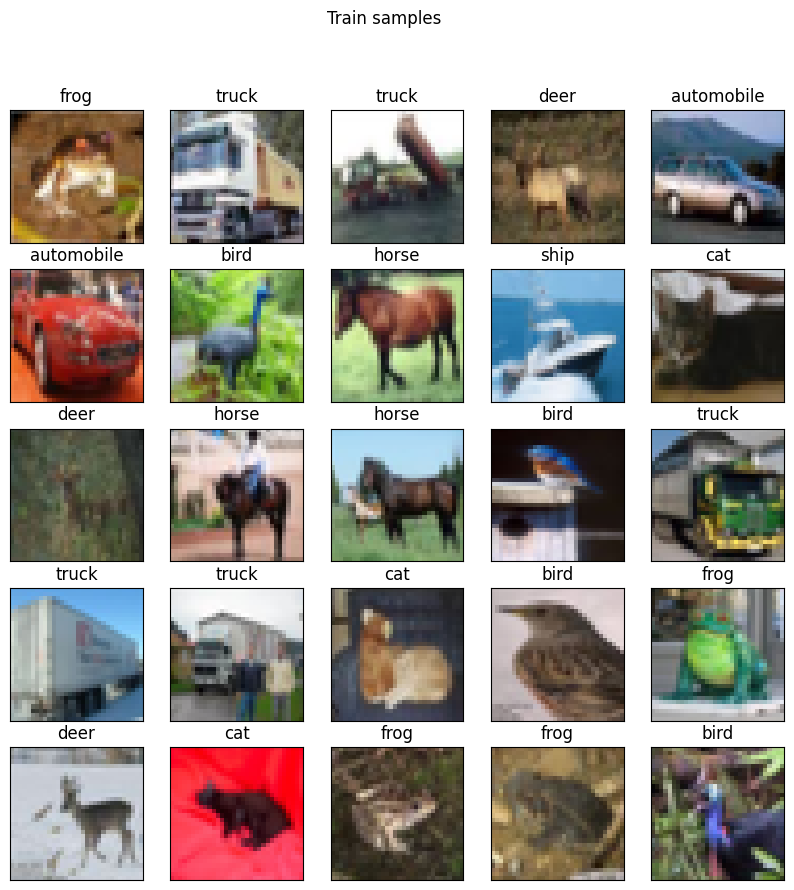

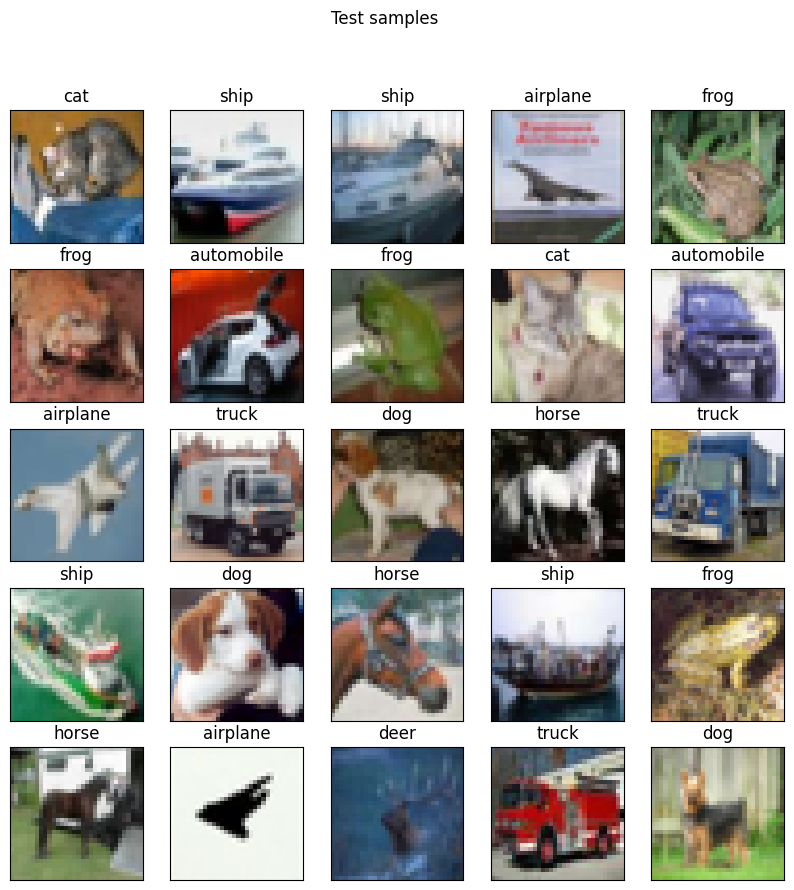

In [6]:
print('Number of train samples: {}'.format(len(train_dataset)))
show_images(train_dataset, 'Train samples')

print('Number of test samples: {}'.format(len(test_dataset)))
show_images(test_dataset, 'Test samples')


Label: 6


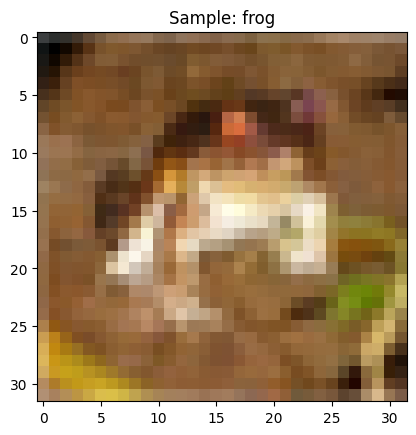

In [7]:
def view_image(image, title):
    img = image[0].numpy().transpose(1, 2, 0)
    plot.title("{}: {}".format(title, class_names[image[1]]))
    plot.imshow((img * 255).astype('uint8'))
view_image(train_dataset[0], 'Sample')
print('Label: {}'.format(train_dataset[0][1]))

Label: 4


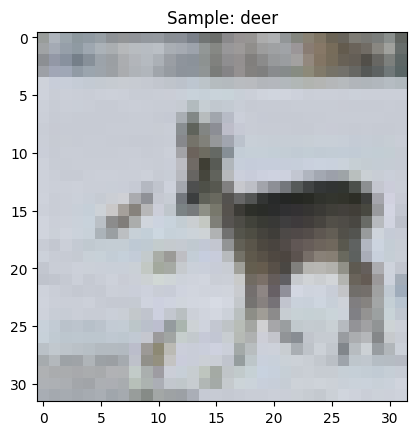

In [8]:
def view_image(image, title):
    img = image[0].numpy().transpose(1, 2, 0)
    plot.title("{}: {}".format(title, class_names[image[1]]))
    plot.imshow((img * 255).astype('uint8'))
view_image(train_dataset[20], 'Sample')
print('Label: {}'.format(train_dataset[20][1]))

In [9]:
print("Обучающая выборка: ")
print(train_dataset.data.shape)
print(len(train_dataset.targets))
print("Тестовая выборка: ")
print(test_dataset.data.shape)
print(len(test_dataset.targets))

Обучающая выборка: 
(50000, 32, 32, 3)
50000
Тестовая выборка: 
(10000, 32, 32, 3)
10000


# Загрузка и обработка данных для обучения модели

In [10]:
means, stds = get_norm_params(train_dataset)

transform_train = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(means, stds)
    ]
)
means, stds = get_norm_params(test_dataset)
transform_test = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(means, stds)
    ]
)

train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = transform_train
)
test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = transform_test
)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False)

# Построение CNN (архитектура ResNet)

In [12]:
class MYResNet(torch.nn.Module):
  def __init__(self):
      super(MYResNet, self).__init__()
      self.conv1 = torch.nn.Sequential(
        torch.nn.Conv2d(3, 64, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(inplace=True)
    )
      self.conv_and_pool_1 = torch.nn.Sequential(
        torch.nn.Sequential(
        torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(inplace=True)
    ),
        torch.nn.MaxPool2d(kernel_size=2)
      )
      self.res1 = torch.nn.Sequential(
        torch.nn.Sequential(
        torch.nn.Conv2d(128, 128, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(inplace=True)
    ),
        torch.nn.Sequential(
        torch.nn.Conv2d(128, 128, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(inplace=True)
    )
      )
      self.conv_and_pool_2 = torch.nn.Sequential(
        torch.nn.Sequential(
        torch.nn.Conv2d(128, 256, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(256),
        torch.nn.ReLU(inplace=True)
    ),
          torch.nn.MaxPool2d(kernel_size=2)
      )
      self.conv_and_pool_3 = torch.nn.Sequential(
        torch.nn.Sequential(
        torch.nn.Conv2d(256, 512, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(512),
        torch.nn.ReLU(inplace=True)
    ),
          torch.nn.MaxPool2d(kernel_size=2)
      )
      self.res2 = torch.nn.Sequential(
        torch.nn.Sequential(
        torch.nn.Conv2d(512, 512, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(512),
        torch.nn.ReLU(inplace=True)
    ),
        torch.nn.Sequential(
        torch.nn.Conv2d(512, 512, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(512),
        torch.nn.ReLU(inplace=True)
    )
      )
      self.final_pool = torch.nn.MaxPool2d(kernel_size=4)
      self.dense = torch.nn.Sequential(
          torch.nn.Flatten(),
          torch.nn.Dropout(0.2),
          torch.nn.Linear(512, 10)
      )

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv_and_pool_1(out)
    out = self.res1(out) + out
    out = self.conv_and_pool_2(out)
    out = self.conv_and_pool_3(out)
    out = self.res2(out) + out
    out = self.final_pool(out)
    out = self.dense(out)
    return out

## Определим объект класса и выведем данные о нем

In [13]:
Network = MYResNet()
Network

MYResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_and_pool_1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

# Обучение модели:

In [17]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Network.parameters(), lr = learning_rate)

def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

def get_loss(model, data_loader, device):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += loss_function(outputs, labels)
            n += labels.size(0)
    return loss / n

def accuracy(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)
  return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

## Выведем данные обучения:

In [18]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Network.parameters(), lr = learning_rate)
print('Training parameters: learning rate = {}, batch size = {}, number of epochs = {}'.format(learning_rate, batch_size, epochs))

Training parameters: learning rate = 0.001, batch size = 128, number of epochs = 25


In [19]:
def train(Network):
    for epoch in range(epochs):
        start = time.time()
        losses = []
        for i, (images, labels) in enumerate(train_data_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = Network(images)
            loss = loss_function(outputs, labels)
            losses.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        duration = time.time() - start
        print('Epoch[{}]: loss = {}, accuracy = {}, time = {}'.format(epoch, torch.stack(losses).mean(), get_accuracy(Network,train_data_loader, device), duration))
    print('Test accuracy: {}'.format(get_accuracy(Network,test_data_loader, device)))
    print('Test loss: {}'.format(get_loss(Network,test_data_loader, device)))

In [ ]:
train(Network)